In [93]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np


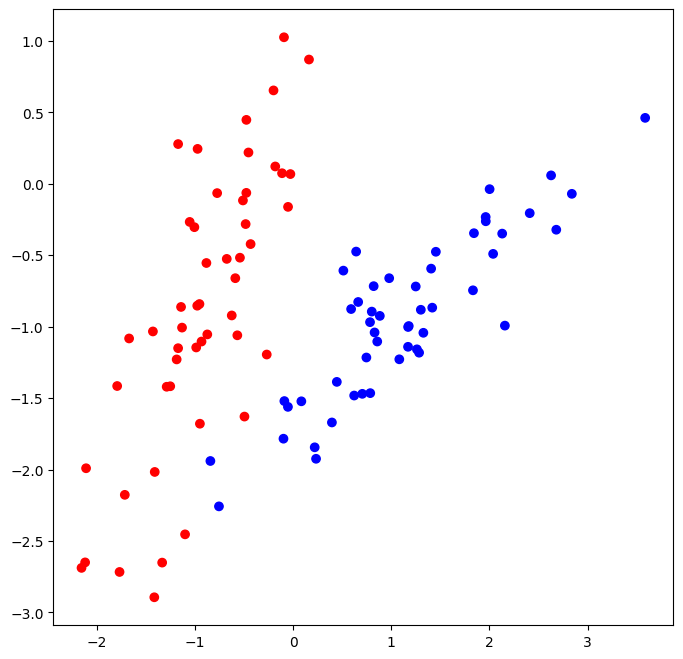

In [94]:
# сгенерируем и визуализируем данные
classification_data, classification_labels = datasets.make_classification(n_features = 2, n_informative = 2,
                                                      n_classes = 2, n_redundant=0,
                                                      n_clusters_per_class=1, random_state=5)

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)),
              c=classification_labels, cmap=colors)
plt.show()

In [95]:
# Реализуем класс узла

class Node:

    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведётся сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [96]:
# Реализуем класс листа

class Leaf:

    def __init__(self, data, labels):
        # self.data = data
        self.labels = labels
        self.prediction = self.predict()

    def predict(self):
        counts = np.bincount(self.labels)
        return np.argmax(counts)

In [ ]:
# Расчёт критерия Джини

def gini(labels):
    _, counts = np.unique(labels, return_counts=True) # все уникальные значения меток и их количества
    probs = counts / counts.sum()
    impurity = 1.0 - np.sum(probs ** 2)
    return impurity

# Расчёт качества

def quality(left_labels, right_labels, current_gini):
    n = len(left_labels) + len(right_labels)
    p_left = len(left_labels) / n
    p_right = len(right_labels) / n
    gain = current_gini - (p_left * gini(left_labels) + p_right * gini(right_labels))
    return gain

# Разбиение выборки на две части

def split(data, labels, index, t):
    # true - те, у кого признак index >= t
    mask = data[:, index] >= t
    true_data = data[mask]
    false_data = data[~mask]
    true_labels = labels[mask]
    false_labels = labels[~mask]
    return true_data, false_data, true_labels, false_labels

# Нахождение наилучшего разбиения

def find_best_split(data, labels):

    min_leaf = 5

    best_quality = 0
    best_t = None
    best_index = None

    current_gini = gini(labels)
    n_features = data.shape[1]

    mf = max(1, int(np.sqrt(n_features)))

    if mf >= n_features:
        features_to_try = list(range(n_features))
    else:
        features_to_try = random.sample(range(n_features), mf)

    for index in features_to_try:
        # возможные пороги — средние между уникальными значениями признака
        feature_values = np.unique(data[:, index])
        if len(feature_values) == 1:
            continue
        thresholds = (feature_values[:-1] + feature_values[1:]) / 2.0

        for t in thresholds:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

            if len(true_labels) < min_leaf or len(false_labels) < min_leaf:
                continue

            current_quality = quality(true_labels, false_labels, current_gini)

            if current_quality > best_quality:
                best_quality = current_quality
                best_t = t
                best_index = index

    return best_quality, best_t, best_index


# Построение дерева посредством рекурсивной функции
def build_tree(data, labels):

    best_quality, best_t, best_index = find_best_split(data, labels)

    if best_quality == 0 or best_index is None:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, best_index, best_t)

    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    return Node(best_index, best_t, true_branch, false_branch)


# Проход объекта по дереву для его классификации

def classify_object(obj, node):
    # obj - одномерный массив признаков
    if isinstance(node, Leaf):
        return node.prediction

    if obj[node.index] >= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

# Предсказание деревом для всего датасета

def predict(data, tree):
    preds = []
    for i in range(data.shape[0]):
        preds.append(classify_object(data[i], tree))
    return preds

In [98]:
def build_forest(data, labels, n_trees=5):

    n = data.shape[0]

    forest = []
    for _ in range(n_trees):
        # бутстрэп
        indices = [random.randrange(0, n) for _ in range(n)]
        sample_data = data[indices]
        sample_labels = labels[indices]

        tree = build_tree(sample_data, sample_labels)
        forest.append(tree)
    return forest

def predict_forest(data, forest):
    # соберём предсказания всех деревьев
    all_preds = []
    for tree in forest:
        all_preds.append(predict(data, tree))
    all_preds = np.array(all_preds)  # shape (n_trees, n_samples)

    final_preds = []
    for col in all_preds.T:
        counts = np.bincount(col)
        final_preds.append(np.argmax(counts))
    return final_preds

In [99]:
# Разобьём выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data,
                                                                                     classification_labels,
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

# Построим лес по обучающей выборке
# параметры леса можно менять: n_trees, sample_size, max_features, random_state
my_forest = build_forest(train_data, train_labels, n_trees=7)

# Получим ответы для обучающей выборки
train_answers = predict_forest(train_data, my_forest)

# Получим ответы для тестовой выборки
answers = predict_forest(test_data, my_forest)

# Введём функцию подсчёта точности
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

# вычислим точности
train_accuracy = accuracy_metric(train_labels, train_answers)
test_accuracy = accuracy_metric(test_labels, answers)

print(f"Train accuracy = {train_accuracy:.2f}%")
print(f"Test accuracy = {test_accuracy:.2f}%")

Train accuracy = 98.57%
Test accuracy = 93.33%


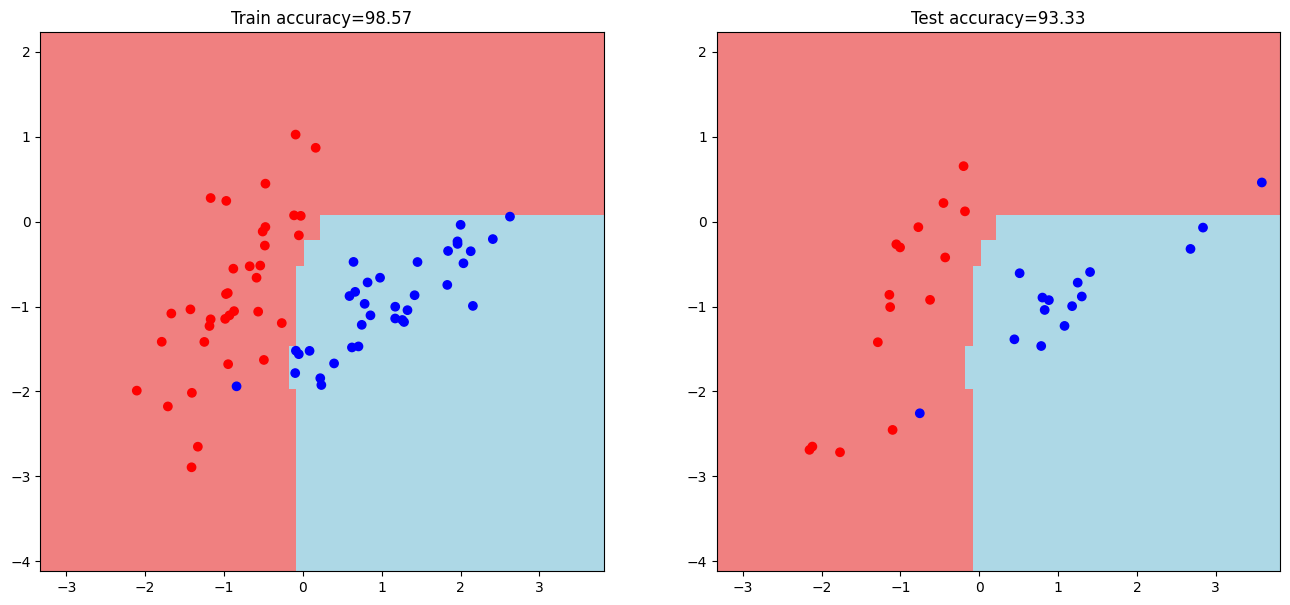

In [100]:
# Визуализируем лес на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_points = np.c_[xx.ravel(), yy.ravel()]
mesh_predictions = np.array(predict_forest(mesh_points, my_forest)).reshape(xx.shape)

plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')
plt.show()